In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content


In [ ]:
import os
os.chdir('/content/drive/My Drive/gc2ae/SN_keras/')
!ls

CBN.py		      img     model.py	__pycache__
CIFAR10-ResNet.ipynb  losses  models	SpectralNormalizationKeras.py


In [ ]:
!pip install q keras==2.2.5
%tensorflow_version 1.x
import keras
keras.__version__

     |████████████████████████████████| 337kB 19.4MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1
TensorFlow 1.x selected.


Using TensorFlow backend.


'2.2.5'

In [ ]:
%matplotlib inline
import keras.backend as K
K.tensorflow_backend._get_available_gpus()

import numpy as np
import matplotlib.pyplot as plt
from time import time

from keras.models import Model, Sequential
from keras.optimizers import Adam
import keras.backend as K
from keras.utils.generic_utils import Progbar

from sklearn.utils import shuffle
import joblib

from model import *

In [ ]:
# for resist GPU memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

In [ ]:
from keras.datasets import cifar100, cifar10, mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [ ]:
X = np.concatenate((x_test,x_train))
print(X.shape)

Y = np.concatenate((y_test,y_train))
print(Y.shape)

(70000, 28, 28)
(70000,)


In [ ]:
X = np.expand_dims(X, axis=-1)
print(X.shape)

(70000, 28, 28, 1)


4


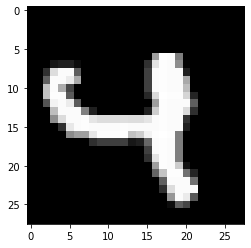

In [ ]:
idx = 9492
print(Y[idx])
plt.imshow(X[idx,:,:,0],cmap='gray')

In [ ]:
#Hyperperemeter
BATCHSIZE=64
LEARNING_RATE = 0.0002
TRAINING_RATIO = 2
BETA_1 = 0.0
BETA_2 = 0.9
EPOCHS = 500
BN_MIMENTUM = 0.9
BN_EPSILON  = 0.00002
SAVE_DIR = 'img/generated_img_CIFAR10_ResNet/'

NUM_CLASSES = 10

GENERATE_ROW_NUM = 8
GENERATE_BATCHSIZE = GENERATE_ROW_NUM*GENERATE_ROW_NUM

In [ ]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

def crammer_singer_criterion(y_true, y_pred):
    mask = tf.math.equal(y_true,1) #Get indices for target labels
    mask_inv = tf.logical_not(mask) #Get indices for other labels
    
    shape1 = tf.stack((tf.shape(y_pred)[0],))
    shape2 = tf.stack((tf.shape(y_pred)[0],tf.shape(y_pred)[1]-1))
    
    #Predicted values for target label
    target = tf.reshape(tf.boolean_mask(y_pred,mask),shape1) 
    
    #Max predicted value for wrong label
    max_wrong = tf.math.reduce_max(tf.reshape(tf.boolean_mask(y_pred,mask_inv),
                                              shape2),axis=1)
    
    return tf.reduce_mean(tf.nn.relu(1 + max_wrong - target))

def fm_loss(y_true, y_pred):
    target_features_mean = tf.reduce_mean(y_true,axis=0)
    pred_features_mean = tf.reduce_mean(y_pred,axis=0)
    abs_diff = tf.math.abs(target_features_mean - pred_features_mean)
    return tf.reduce_mean(abs_diff)

In [ ]:
def onehotencode(a,wgan=True):
    a = a.reshape((a.shape[0],))
    if wgan:
        b = np.ones((a.size, a.max()+1),dtype=np.int32)*-1
    else:
        b = np.zeros((a.size, a.max()+1),dtype=np.int32)
    b[np.arange(a.size),a] = 1
    return b

In [ ]:
#CIFAR
#generator = BuildGenerator(bn_momentum=BN_MIMENTUM, bn_epsilon=BN_EPSILON,cbn=CBN)
#discriminator = BuildDiscriminator(cbn=CBN)

#MNIST
generator = BuildGenerator(cbn=NUM_CLASSES,resblock3=False,
                           spectral_normalization=True,
                           out_channels=1,init_shape=(7,7,256))
#CS LOSS
discriminator = BuildDiscriminatorCS(num_classes=NUM_CLASSES,in_shape=(28,28,1))








Generator
Spectral Normalization: True
Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
dense_sn_1 (DenseSN)            (None, 12544)        1630720     input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 7, 7, 256)    0           dense_sn_1[0][0]                 
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
____________________________________________

In [ ]:
Noise_input_for_training_generator = Input(shape=(128,))
Class_input_for_training_generator = Input(shape=(1,),dtype='int32')
Generated_image                    = generator([Noise_input_for_training_generator,
                                               Class_input_for_training_generator])
Discriminator_output               = discriminator(Generated_image)
model_for_training_generator       = Model([Noise_input_for_training_generator,
                                            Class_input_for_training_generator], 
                                           Discriminator_output)
print("model_for_training_generator")
discriminator.trainable = False
model_for_training_generator.summary()
model_for_training_generator.compile(optimizer=Adam(LEARNING_RATE, 
                                                    beta_1=BETA_1, 
                                                    beta_2=BETA_2), 
                                     loss=crammer_singer_criterion)

model_for_training_generator
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 128)          0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
Generator (Model)               (None, 28, 28, 1)    4154626     input_12[0][0]                   
                                                                 input_13[0][0]                   
__________________________________________________________________________________________________
Discriminator (Model)           (None, 11)           1057434   

In [ ]:
#WLOSS
in_shape = (28,28,1)
Real_image                             = Input(shape=in_shape)
Noise_input_for_training_discriminator = Input(shape=(128,))
Class_input_for_training_generator     = Input(shape=(1,),dtype='int32')
Fake_image                             = generator([Noise_input_for_training_discriminator,
                                                    Class_input_for_training_generator])

Discriminator_output_for_real          = discriminator(Real_image)
Discriminator_output_for_fake          = discriminator(Fake_image)

model_for_training_discriminator       = Model([Real_image,
                                                Noise_input_for_training_discriminator,
                                                Class_input_for_training_generator],
                                               [Discriminator_output_for_real,
                                                Discriminator_output_for_fake])
print("model_for_training_discriminator")
generator.trainable = False
discriminator.trainable = True
model_for_training_discriminator.compile(optimizer=Adam(LEARNING_RATE, 
                                                        beta_1=BETA_1, 
                                                        beta_2=BETA_2), 
                                         loss=[crammer_singer_criterion, 
                                               crammer_singer_criterion])
model_for_training_discriminator.summary()

model_for_training_discriminator
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 128)          0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
Generator (Model)               (None, 28, 28, 1)    4154626     input_15[0][0]                   
                                                           

In [ ]:
real_y = onehotencode(Y+1,wgan=True)
fake_y = np.ones_like(real_y)*-1
fake_y[:,0] = 1

print(Y[:5])
print(real_y[:5])
print(fake_y[:5])

assert np.sum(real_y[:,0])*-1 == len(real_y)
assert np.sum(fake_y[:,0]) == len(real_y)

[7 2 1 0 4]
[[-1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1]
 [-1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1]]
[[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


In [ ]:
X = X/255*2-1

In [ ]:
assert np.min(X) == -1
assert np.max(X) == 1

In [ ]:
test_noise = np.random.randn(GENERATE_BATCHSIZE, 128)
test_class = Y[:GENERATE_BATCHSIZE]
test_class_ohe = real_y[:GENERATE_BATCHSIZE]

print(test_class)

[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3]


In [ ]:
EPOCHS=250

In [ ]:
image_dim = 28 #32
image_channels = 1 #3
CS_loss = []
discriminator_loss = []
generator_loss = []
for epoch in range(EPOCHS):
    X,Y,real_y = shuffle(X,Y,real_y)
    
    print("epoch {} of {}".format(epoch+1, EPOCHS))
    num_batches = int(X.shape[0] // BATCHSIZE)
    
    print("number of batches: {}".format(int(X.shape[0] // (BATCHSIZE))))
    
    progress_bar = Progbar(target=int(X.shape[0] // (BATCHSIZE * TRAINING_RATIO)))
    minibatches_size = BATCHSIZE * TRAINING_RATIO
    
    start_time = time()
    for index in range(int(X.shape[0] // (BATCHSIZE * TRAINING_RATIO))):
        progress_bar.update(index)
        discriminator_minibatches_X = X[index * minibatches_size:(index + 1) * minibatches_size]
        discriminator_minibatches_Y = Y[index * minibatches_size:(index + 1) * minibatches_size]

        minibatches_real_y = real_y[index * minibatches_size:(index + 1) * minibatches_size]
        minibatches_fake_y = fake_y[index * minibatches_size:(index + 1) * minibatches_size]
        
        for j in range(TRAINING_RATIO):
            image_batch = discriminator_minibatches_X[j * BATCHSIZE : (j + 1) * BATCHSIZE]
            class_batch = discriminator_minibatches_Y[j * BATCHSIZE : (j + 1) * BATCHSIZE]
            real_y_batch = minibatches_real_y[j * BATCHSIZE : (j + 1) * BATCHSIZE]
            fake_y_batch = minibatches_fake_y[j * BATCHSIZE : (j + 1) * BATCHSIZE]
            noise = np.random.randn(BATCHSIZE, 128).astype(np.float32)
            discriminator.trainable = True
            generator.trainable = False
            discriminator_loss.append(model_for_training_discriminator.train_on_batch([image_batch, 
                                                                                       noise, 
                                                                                       class_batch],
                                                                                      [real_y_batch, fake_y_batch]))
        discriminator.trainable = False
        generator.trainable = True
        generator_loss.append(model_for_training_generator.train_on_batch([np.random.randn(BATCHSIZE, 128),
                                                                           class_batch], real_y_batch))
    
    print('\nepoch time: {}'.format(time()-start_time))
    
    W_real = model_for_training_generator.evaluate([test_noise,
                                                    test_class], test_class_ohe)
    print(W_real)
    W_fake = model_for_training_generator.evaluate([test_noise,
                                                    test_class], fake_y_batch)
    print(W_fake)
    W_l = W_real+W_fake
    print('CS_loss: {}'.format(W_l))
    CS_loss.append(W_l)
    #Generate image
    generated_image = generator.predict([test_noise,
                                         test_class])
    generated_image = (generated_image+1)/2
    for i in range(GENERATE_ROW_NUM):
        if image_channels == 1:
            new = generated_image[i*GENERATE_ROW_NUM:i*GENERATE_ROW_NUM+GENERATE_ROW_NUM].reshape(image_dim*GENERATE_ROW_NUM,
                                                                                              image_dim)
        else:
            new = generated_image[i*GENERATE_ROW_NUM:i*GENERATE_ROW_NUM+GENERATE_ROW_NUM].reshape(image_dim*GENERATE_ROW_NUM,
                                                                                              image_dim,image_channels)
        if i!=0:
            old = np.concatenate((old,new),axis=1)
        else:
            old = new
    print('plot generated_image')
    
    if image_channels == 1:
        plt.imsave('{}/SN_epoch_{}.png'.format(SAVE_DIR, epoch), old, cmap='gray')
    else:
        plt.imsave('{}/SN_epoch_{}.png'.format(SAVE_DIR, epoch), old)

epoch 1 of 250
number of batches: 1093
  0/546 [..............................] - ETA: 0sWARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.




545/546 [============================>.] - ETA: 0s
epoch time: 214.9693877696991
64/64 [==============================] - 1s 21ms/step
5.62076473236084
64/64 [==============================] - 0s 945us/step
0.00193009153008461
CS_loss: 5.6226948238909245
plot generated_image
epoch 2 of 250
number of batches: 1093
545/546 [============================>.] - ETA: 0s
epoch time: 186.6065890789032
64/64 [==============================] - 0s 830us/step
5.85899019241333
64/64 [==============================] - 0s 842us/step
0.02184349298477173
CS_loss: 5.880833685398102
plot generated_image
epoch 3 of 250
number of batches: 1093
545/546 [============================>.] - ETA: 0s
epoch time: 187.46565532684326
64/64 [=

KeyboardInterrupt: ignored

In [ ]:
model_for_training_discriminator.metrics_names

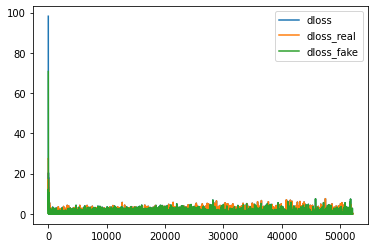

In [ ]:
disc_loss = np.array(discriminator_loss)
d_loss = disc_loss[:,0]
d_loss_real = disc_loss[:,1]
d_loss_fake = disc_loss[:,2]
plt.plot(d_loss,label='dloss')
plt.plot(d_loss_real,label='dloss_real')
plt.plot(d_loss_fake,label='dloss_fake')
plt.legend(loc='best')

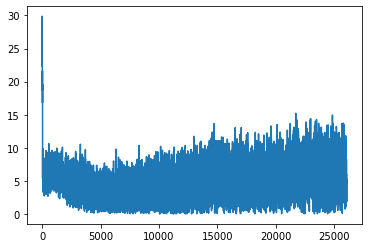

In [ ]:
plt.plot(generator_loss)

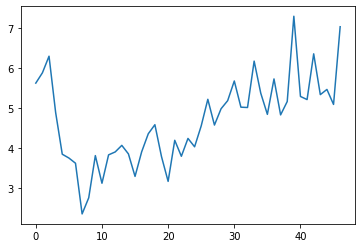

In [ ]:
plt.plot(CS_loss)

In [ ]:
MODEL_DIR = 'models/disc_SN/'
model_for_training_generator.save(MODEL_DIR+'model_for_training_generator_ep250_mnist.h5')
model_for_training_discriminator.save(MODEL_DIR+'model_for_training_discriminator_ep250_mnist.h5')
generator.save(MODEL_DIR+'generator_ep250_mnist.h5')
discriminator.save(MODEL_DIR+'discriminator_ep250_mnist.h5')

In [ ]:
import joblib

LOSS_DIR = 'losses/disc_SN/'

joblib.dump(discriminator_loss,LOSS_DIR+'discriminator_loss_ep250_mnist.pkl')
joblib.dump(generator_loss,LOSS_DIR+'generator_loss_ep250_mnist.pkl')
joblib.dump(W_loss,LOSS_DIR+'W_loss_ep250_mnist.pkl')

['W_loss_ep230_cifar10.pkl']